In [ ]:
!apt -qq -y install fonts-nanum > /dev/null

import requests
import time
from collections import defaultdict
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

import logging
import matplotlib.font_manager

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [ ]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
TOKEN = '깃헙 토큰'
HEADERS = {'Authorization': f'token {TOKEN}'}

In [ ]:
# 이 사람이 한국인인가?
def is_korean(user):
    if not user:
        return False
    bio = (user.get("bio") or "").lower()
    location = (user.get("location") or "").lower()
    return any(k in bio or k in location for k in ['korea', 'seoul', 'busan', '대한민국', '한국'])

# PR 데이터 수집
def fetch_all_prs():
    page = 1
    all_prs = []
    while True:
        url = f"https://api.github.com/repos/apache/airflow/pulls?state=all&per_page=100&page={page}"
        res = requests.get(url, headers=HEADERS)
        prs = res.json()
        if not prs or res.status_code != 200:
            break
        all_prs.extend(prs)
        print(f"Fetched page {page}, total: {len(all_prs)}")
        page += 1
        time.sleep(1)
    return all_prs

user_cache = {}

# User 정보 수집
def get_user(login):
    if login in user_cache:
        return user_cache[login]
    res = requests.get(f"https://api.github.com/users/{login}", headers=HEADERS)
    if res.status_code == 200:
        user_data = res.json()
        user_cache[login] = user_data
        time.sleep(0.5)
        return user_data
    return None

# PR 중 한국인 기여자 필터링
def analyze_korean_contributors(prs):
    stats = defaultdict(lambda: {"total": 0, "korean": 0})
    for pr in tqdm(prs, desc="분석 중"):
        created = pr["created_at"][:7]  # YYYY-MM
        login = pr["user"]["login"]
        stats[created]["total"] += 1
        user_data = get_user(login)
        if is_korean(user_data):
            stats[created]["korean"] += 1
    return stats

prs = fetch_all_prs()
stats = analyze_korean_contributors(prs)

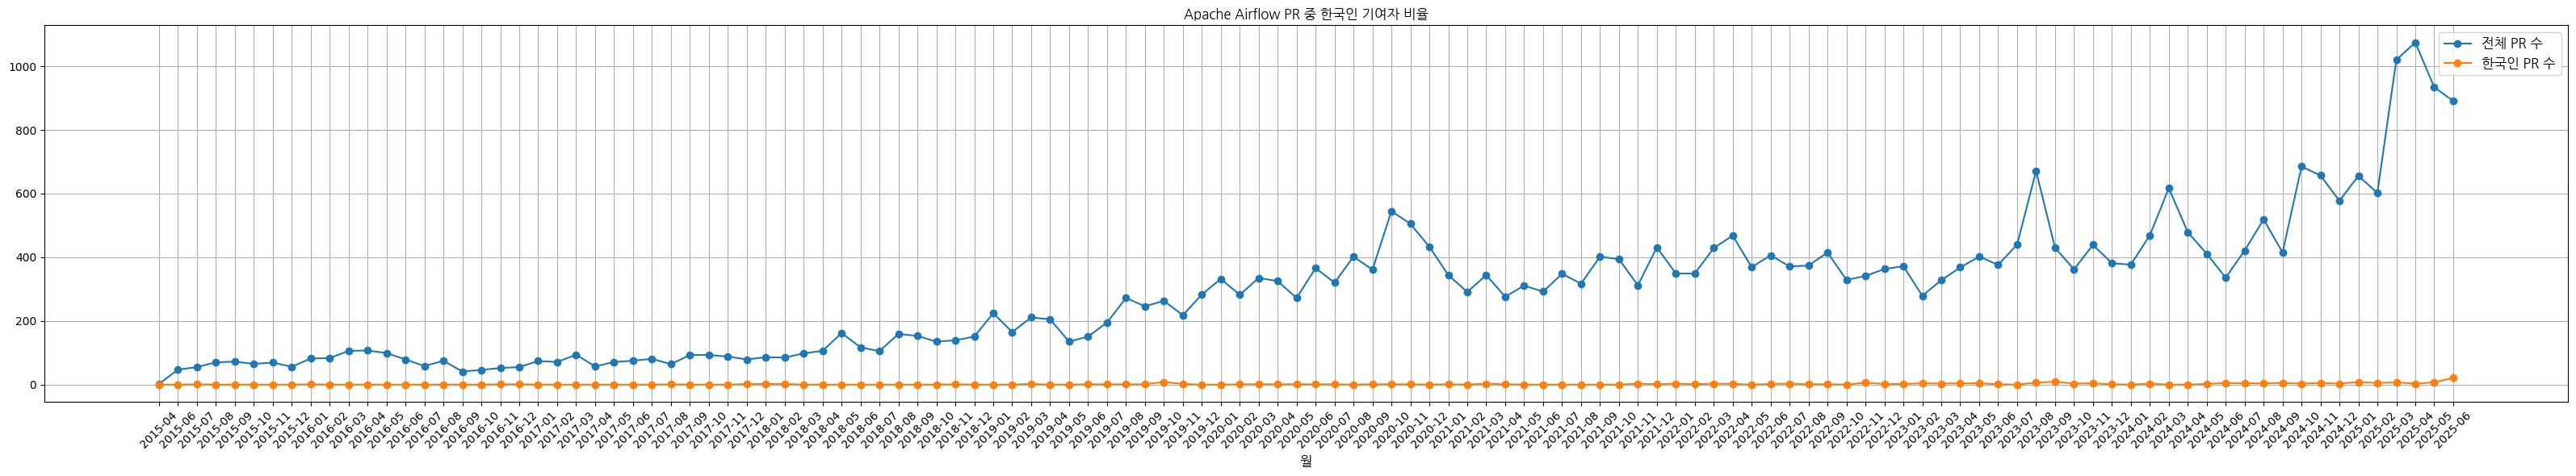

In [ ]:
def plot_stats(stats, font_prop):
    df = pd.DataFrame([
        {"month": month, "total": data["total"], "korean": data["korean"]}
        for month, data in sorted(stats.items())
    ])
    df["ratio"] = df["korean"] / df["total"] * 100

    plt.figure(figsize=(32, 6))
    plt.plot(df["month"], df["total"], label="전체 PR 수", marker='o')
    plt.plot(df["month"], df["korean"], label="한국인 PR 수", marker='o')

    plt.xticks(rotation=45)
    plt.legend(prop=font_prop)
    plt.grid(True)

    plt.title("Apache Airflow PR 중 한국인 기여자 비율", fontproperties=font_prop)
    plt.xlabel("월", fontproperties=font_prop)

    plt.tight_layout()
    plt.show()

plot_stats(stats, font_prop)

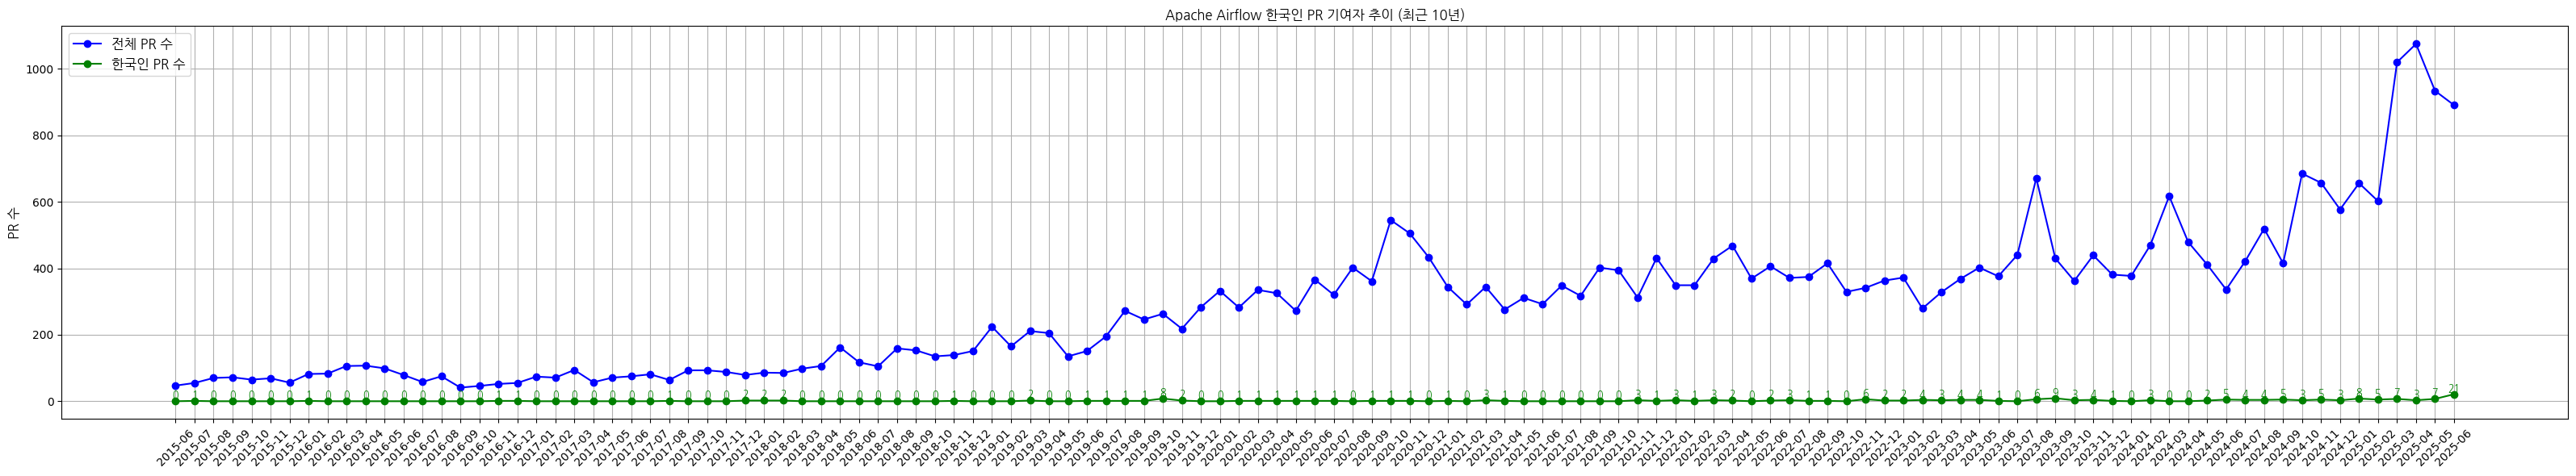

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def plot_stats(stats, font_prop, years=10):
    from datetime import datetime
    from dateutil.relativedelta import relativedelta

    now = datetime.now()
    cutoff = now - relativedelta(years=years)
    cutoff_str = cutoff.strftime("%Y-%m")

    filtered_stats = {
        month: data for month, data in stats.items()
        if month >= cutoff_str
    }

    df = pd.DataFrame([
        {"month": month, "total": data["total"], "korean": data["korean"]}
        for month, data in sorted(filtered_stats.items())
    ])

    df["ratio"] = df["korean"] / df["total"] * 100

    fig, ax1 = plt.subplots(figsize=(32, 6))

    ax1.set_title(f"Apache Airflow 한국인 PR 기여자 추이 (최근 {years}년)", fontproperties=font_prop)
    ax1.plot(df["month"], df["total"], label="전체 PR 수", marker='o', color='blue')
    line_korean, = ax1.plot(df["month"], df["korean"], label="한국인 PR 수", marker='o', color='green')
    ax1.set_ylabel("PR 수", fontproperties=font_prop)
    ax1.tick_params(axis='y')

    for x, y in zip(df["month"], df["korean"]):
        ax1.text(x, y, str(y), fontsize=9, fontproperties=font_prop,
                 ha='center', va='bottom', color='green')

    lines1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='upper left', prop=font_prop)

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_stats(stats, font_prop)

